# Implementing Density Functional Theory using Deepchem

Author: Rakshit Kumar Singh : [LinkedIn](https://www.linkedin.com/in/rakshit-singh-ai/) : [Blog](blog.greatrsingh.in)

## Introduction

Density Functional Theory (DFT) has emerged as a cornerstone of computational quantum mechanics, offering a powerful framework for understanding and predicting the electronic structure of materials. Its ability to provide accurate insights into molecular interactions, material properties, and electronic behaviors has made it indispensable in physics, chemistry, and materials science. In this tutorial, we focus on the practical implementation of DeepChem DFT tooling, an innovative integration that combines the flexibility of the DeepChem library with the rigor of DFT calculations.

DeepChem, an open-source Python library designed for machine learning applications in computational chemistry, drug discovery, and materials science, offers robust tools for molecular featurization, pre-trained models, and quantum chemistry workflows. This integration enables users to efficiently perform DFT-based calculations, predict DFT-derived properties, and explore material characteristics at the atomic and molecular levels. By leveraging DeepChem’s machine learning capabilities, the tool enhances traditional DFT workflows, providing faster predictions and enabling seamless customization. Whether you're an expert in computational science or new to the field, this tutorial will guide you in using DeepChem's DFT features to streamline your research and unlock the potential of quantum mechanics and machine learning in materials modeling.

It is suggested to go through the earlier tutorial `Training an Exchange Correlation Functional using Deepchem` by Advika Vidhyadhiraja which helps us understand how Exchange Correlation Functionals works and how it can be easily implemented using Deepchem. This tutorial is a build up on the fundamentals established by the earlier tutorial.

## Understanding Density Functional Theory (DFT)

Density Functional Theory (DFT) is a quantum mechanical framework that simplifies the many-body problem of electrons in a system by expressing the total energy as a functional of the electron density, $\rho(r)$. Unlike wavefunction-based approaches that depend on $3N$ spatial coordinates for $N$ electrons, DFT reduces the complexity to a three-dimensional function, $\rho(r)$, representing the probability density of electrons at position $r$. The foundational theorem, established by Hohenberg and Kohn, proves that the ground-state properties of a many-electron system are uniquely determined by $\rho(r)$.

The total energy $E[\rho]$ is expressed as a sum of functionals:

$E[\rho]$ = $T[\rho]$ + $V_{ext}[\rho]$ + $V_H[\rho]$ + $E_{XC}[ρ]$,

where $T[\rho]$ is the kinetic energy, $V_{ext}[\rho]$ is the external potential energy, $V_H​[\rho]$ is the Hartree energy accounting for electron-electron Coulomb repulsion, and $E_{XC}​[\rho]$ is the exchange-correlation energy functional.

The exact form of $E_{XC}​[ρ]$ remains unknown and is approximated using methods like the Local Density Approximation (LDA) or Generalized Gradient Approximation (GGA). In Deepchem we have `HybridXC` class which acts as a frontent api for performing XC approximations, it combines the tradition LDA approximation with a neural network based LDA.


## Installing required libraries

In [1]:
#%pip install tqdm pyyaml basis_set_exchange git+https://github.com/diffqc/dqclibs.git h5py matplotlib
#%conda install conda-forge::pylibxc

# Parse Molecular Description class

Parse the string of molecular descriptor and returns tensors of atomic number and atom positions.

In [12]:
from deepchem.utils.dft_utils import parse_moldesc
system = {
    'type': 'mol',
    'kwargs': {
        'moldesc': 'H 0.86625 0 0; F -0.86625 0 0',
        'basis': '6-311++G(3df,3pd)'
    }
}
atomzs, atomposs = parse_moldesc(system["kwargs"]["moldesc"])
print("Atomic Numbers: \n", atomzs)
print("\n")
print("Position of Atoms: \n", atomposs)

Atomic Numbers: 
 tensor([1., 9.], dtype=torch.float64)


Position of Atoms: 
 tensor([[ 0.8662,  0.0000,  0.0000],
        [-0.8662,  0.0000,  0.0000]], dtype=torch.float64)


# Using Mol Class

The Mol class provides a structured framework for describing an isolated molecule in computational chemistry. It encapsulates critical information about the atoms, bonding, geometry, charge distribution, and electronic properties of the molecule, offering a comprehensive system for simulating and analyzing molecular behavior. By using the Mol class, researchers can gain valuable insights into a molecule's structure and properties, facilitating the exploration of its reactivity, stability, and potential applications in various scientific fields.

In [22]:
from deepchem.utils.dft_utils import Mol

mol = Mol(system["kwargs"]["moldesc"], system["kwargs"]["basis"], spin=0, charge=0)

mol.densityfit().get_hamiltonian().nao

57

### Datasets Used

The `XCModel` is trained using four types of data points: atomization energy (AE) calculations, ionization potential (IP) calculations, density profile regulations, and density matrix calculations. The ground truth values for AE and IP are sourced from NIST databases (Kasim & Vinko, 2021), while the density-related data points are generated through Coupled Cluster Singles and Doubles (CCSD) calculations using PYSCF. Users are not required to manually input the equations for computing the total energy of AE and IP data points, as these calculations are handled internally. To streamline data preparation, we have implemented the `DFTYamlLoader` class in DeepChem, which automates data loading, preparation, and featurization into standardized molecular representations.

#### DFTYamlLoader and DFT data class

The `DFTEntry` data class is used to create and initialize `DFTEntry` objects from the dataset. Each object contains detailed information about the systems in a data point, such as atoms, molecules, and ions, along with their corresponding ground truth values. A system within a `DFTEntry` object includes attributes like "moldesc" (molecular description), "basis," and "spin" for all atoms or molecules, formatted according to DQC or PYSCF conventions. Systems must be entered in a specific order, with the main atom or molecule listed as the first element. This ordering is particularly important for entries containing equations, such as those for atomization energy (AE) and ionization energy (IE). The spin and charge of a system are optional parameters, defaulting to `0` if not specified. Additionally, the `system number` denotes the frequency of a specific system within a molecule—particularly relevant for polyatomic molecules. For example, in water (H₂O), the `system number` for hydrogen is `2` since there are two hydrogen atoms in the molecule.

In [13]:
from deepchem.data.data_loader import DFTYamlLoader
inputs = 'assets/dft_tutorial.yaml'
data = DFTYamlLoader()
dataset = data.create_dataset(inputs)

### Training the XC Model


The `XCModel` class is designed for initializing and running Differentiable Quantum Chemistry calculations, specifically Density Functional Theory (DFT), using an exchange-correlation functional augmented by a neural network. The model parameters include the PyTorch-based neural network used to train the functional and the choice of loss function. In its forward method, the class initializes the Neural Network LDA (NNXC) layer and combines the neural network functional with a traditional Local Density Approximation (LDA) functional to create a hybrid exchange-correlation model. This hybrid model is then employed to solve the Kohn-Sham equations. Upon convergence of the self-consistent field iterations, the total energy of the system is computed and used to evaluate the loss. The trained `XCModel` integrates seamlessly with DeepChem, allowing functions like `evaluate` and `predict` to be used with various metrics for performance analysis (Kasim & Vinko, 2021; Ramsundar et al., 2021a).

In [ ]:
from deepchem.models.dft.dftxc import XCModel
import tempfile

# create a file to save the model
model_dir = tempfile.mkdtemp()

# initialise the model
model = XCModel("lda_x",
                batch_size=1,
                log_frequency=1,
                mode="classification",
                n_tasks=2,
                model_dir=model_dir)

# Calculate the loss on fitting the model
loss = model.fit(dataset, nb_epoch=10, checkpoint_interval=1)

/home/rakshit/deepchem-1/deepchem/utils/differentiation_utils/optimize/rootsolver.py:178: ConvergenceWarning: The rootfinder does not converge after 50 iterations. Best |dx|=4.647e-01, |f|=2.115e-01 at iter 13
  warnings.warn(ConvergenceWarning(msg))


### Predictions and Analysis Using the Exchange-Correlation (XC) Model

Predictions can be performed on a variety of molecules to analyze their properties. In this tutorial, we will focus on predicting energy values and comparing them by plotting the hydrogen dissociation curve alongside CCSD reference values for evaluation.

In [16]:
# load the datasets
import numpy as np
inputs = 'assets/h2.yaml'
data = DFTYamlLoader()
h2_dataset = data.create_dataset(inputs)
predict = model.predict(h2_dataset)

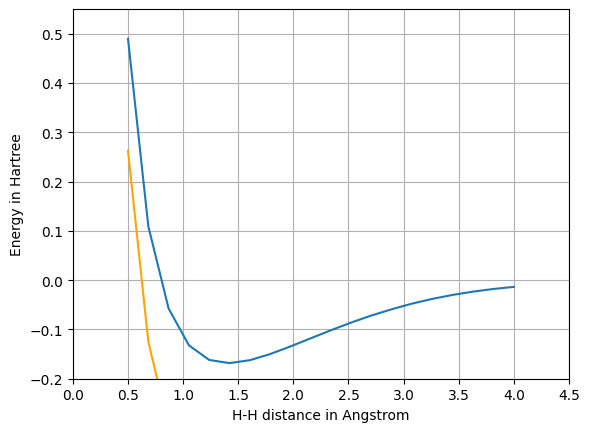

In [17]:
import matplotlib.pyplot as plt 
#plot
true_val = (h2_dataset.y) 
predict_val = (predict)*(-1)
pos = np.array([0.5000, 0.6842, 0.8684, 1.0526, 1.2368,
                1.4211, 1.6053, 1.7895, 1.9737, 2.1579,
                2.3421, 2.5263, 2.7105, 2.8974, 3.0789,
                3.2632, 3.4474, 3.6316, 3.8158, 4.000]) 
plt.plot(pos, true_val )
plt.plot(pos, predict_val, color = 'orange')
y = pos * 0
plt.xlabel("H-H distance in Angstrom") 
plt.ylabel("Energy in Hartree")
plt.xlim([0.0, 4.5])
plt.ylim([-0.2, 0.55])
plt.grid()
plt.show()

## References

[1].. Ramsundar, B., Eastman, P., Walters, P., Pande, V., Leswing, K., Wu, Z. (2019). Deep Learning for the Life Sciences: Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More. O'Reilly Media.

[2].. Sholl, D. S., & Steckel, J. A. (2009). Density functional theory: A practical introduction. Hoboken, NJ: John Wiley & Sons.

## Citing This Tutorial

If you found this tutorial useful please consider citing it using the provided BibTeX.

```bibtex
@manual{Quantum Chemistry, 
 title={Implementing Density Functional Theory using Deepchem}, 
 organization={DeepChem},
 author={Singh, Rakshit kr.},
 howpublished = {\url{https://github.com/deepchem/deepchem/blob/master/examples/tutorials/ODE_Solving.ipynb}}, 
 year={2024}, 
} 
```

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:


## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.


## Join the DeepChem Discord
The DeepChem [Discord](https://discord.gg/SxSzjRRDMA) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!